<a href="https://colab.research.google.com/github/ksemina61/task1semestr/blob/main/Seminar_3_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Логистическая регрессия (конспект).

Логистическая регрессия - линейная модель, отделяющая модель одного класса от модели другого класса. Пример: человек либо вернет кредит, либо не вернет кредит.
Получается есть какая-то точка, которая разделяет классы.
Чем дальше от линии (справа, слева), тем точнее предсказания.
1/1+e^-1
Превращает функцию из линейной в логистическую, по которой мы сможем разделить один класс от другого.
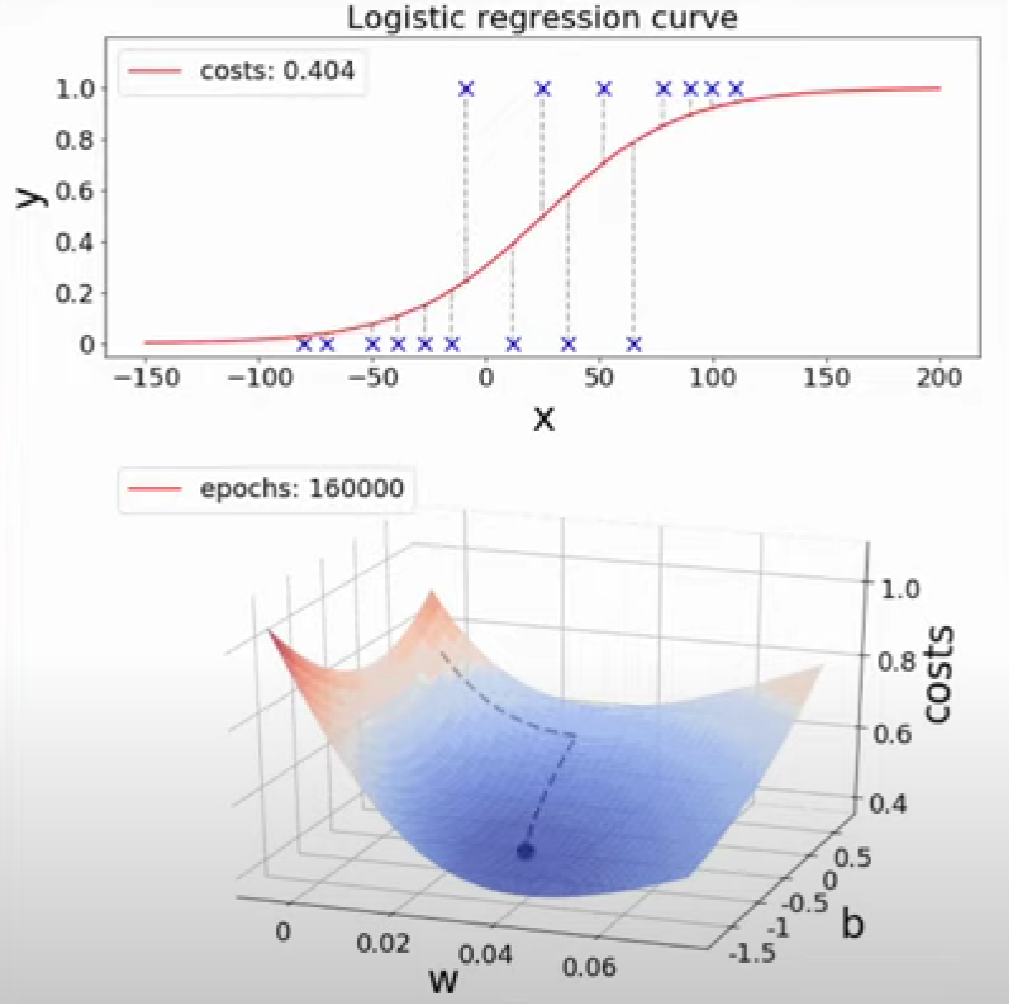
Как строиться логистическая регрессия?

Правдоподобие - показывает насколько вероятный был наблюдаемый набор результатов. Чем больше правдоподобие, тем больше вероятность встретить точки в найденном законе.
Чем меньше logloss (функция потерь), тем лучше. (то есть совершили меньше ошибок). Иногда logloss называют кросс-энтропией.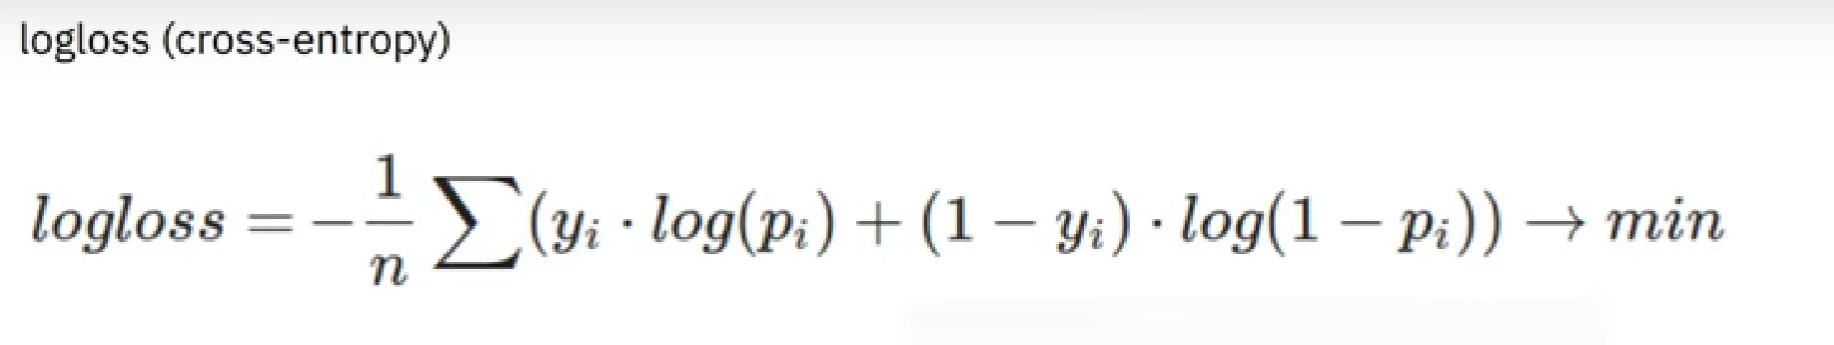

Именно с помощью этой формулы осуществляется градиентный спуск по логичестической регрессии. По этой формуле обучается логистическая регрессия. Ошибка logloss основывается на правдоподобии. Чем эта ошибка меньше, тем выше качество самой модели.
Правдоподобие показывает насколько найденный закон описывает наши данные.
Функция потерь (logloss) - позволяет обучаться регрессия за счет скатывания по logloss в пространстве весов до минимальной ошибки.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

## Решение задачи бинарной классификации

### Логистическая регрессия

y = {-1, 1}

$b(x) = \sigma(<w,x>)$, где $\sigma(z) = \frac{1}{1 + e^{-z}}$

Поработаем с уже известным нам датасетом Titanic.

In [ ]:
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Для начала посмотрим, сколько людей было на корабле:
data.count()
# Примерно 891

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [ ]:
#  Кроме того, у нас есть пустые значения. Посмотрим эти пустые значение Nan: (общее кол-во пустых значений)
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Много пустых значений у Age и Cabin. Создадим Boxplot(ящик с усами).

Box-plot не всегда информативен, однако он нужен, чтобы сравнить две-три группы между собой. Видно, что в PClass во 2 и 3 boxplot достаточно много отклонений.
Попробую посмотреть на функцию вычисления возраста относительно соответствующего среднего возраста в классе.

Медианы примерно 38, 30, 26.

<Axes: xlabel='Pclass', ylabel='Age'>

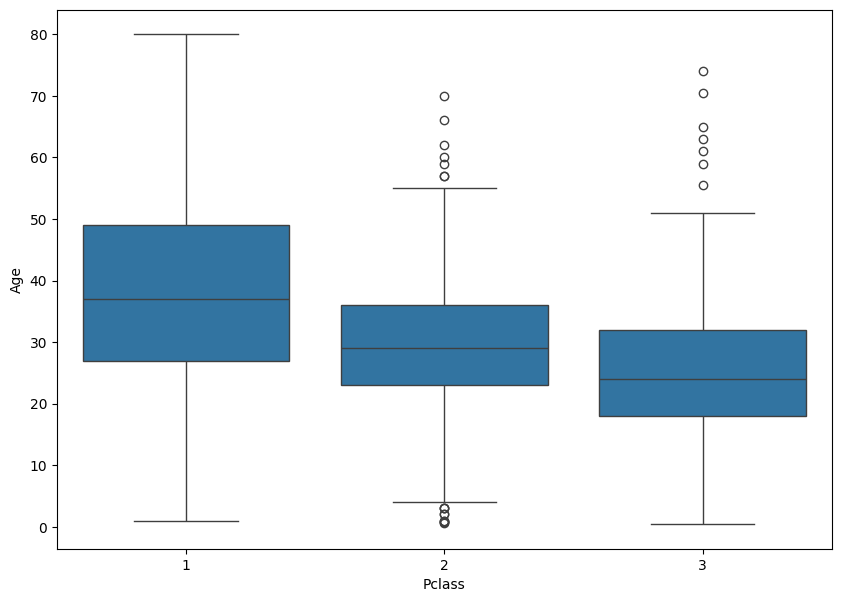

In [ ]:
# Посмотрим средний возраст с помощью boxplot

plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=data)

In [ ]:
def add_age(hello):
  Age = hello[0]
  Pclass = hello[1]
  if pd.isnull(Age):
    return int(data[data["Pclass"] == Pclass]["Age"].mean())
  else:
    return Age

In [ ]:
data["Age"] = data[["Age", "Pclass"]].apply(add_age,axis=1)
# Так как у нас много пустых значений в cabin, то просто дропнем их
data.drop("Cabin",inplace=True,axis=1)

In [ ]:
# Удаляем некоторые строки с нулевыми значениями:
# dropna() удаляет строки, которые содержат хотя бы одно пропущенное значение
data.dropna(inplace=True)
# Так, отлично, данные почистили.
# У нас в датасете есть категориальные признаки, их нужно преобразовать в числовые.

In [ ]:
data.head().copy()
# Метод copy() создает глубокую копию этого подмножества данных.
# Глубокое копирование означает создание нового объекта DataFrame с копиями всех данных, что позволяет изменять новый DataFrame, не затрагивая исходный.
# Нам нужно преобразовать из категориальных в числовые пол, name, ticket и embarked

In [ ]:
# Чтобы из категориальных признаков сделать числовые воспользуюсь get_dummies из библиотеки pandas
pd.get_dummies(data["Sex"])
sex = pd.get_dummies(data["Sex"],drop_first=True) #  мужчина = 1, женщина = 0
# аргумент drop_first, когда установлен в True, удалять первый столбец, чтобы избежать мультиколлинеарности.
# также поступим с mbarked and PClass
embarked = pd.get_dummies(data["Embarked"],drop_first=True)
pclass = pd.get_dummies(data["Pclass"],drop_first=True)

In [ ]:
# pd.concat() - позволяет объединить объекты pandas
data = pd.concat([data, pclass, sex, embarked],axis=1)

In [ ]:
# Дропним то, что не очень нужно
data.drop(["PassengerId","Pclass","Name","Sex","Ticket","Embarked"],axis=1,inplace=True)

In [ ]:
X = data.drop("Survived",axis=1)
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
y.value_counts()

0    549
1    340
Name: Survived, dtype: int64

Баланс не очень. Попробуем посмотреть сразу все скоры.

In [ ]:
# вылезла ошибка Typerror, пришлось  преобразовать данные (int) в строкового типа (str)
X.columns = X.columns.astype(str)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
# Тренируем логистическую регрессию
from sklearn.linear_model import LogisticRegression
#logmodel = LogisticRegression()
#logmodel.fit(X_train,y_train)

In [ ]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)
print(classification_report(ypred_train, y_train), classification_report(ypred_test, y_test))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       477
           1       0.68      0.79      0.73       234

    accuracy                           0.81       711
   macro avg       0.79      0.80      0.79       711
weighted avg       0.82      0.81      0.81       711
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       124
           1       0.63      0.83      0.72        54

    accuracy                           0.80       178
   macro avg       0.77      0.81      0.78       178
weighted avg       0.83      0.80      0.81       178



In [ ]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)
print(classification_report(ypred_train, y_train), classification_report(ypred_test, y_test))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       456
           1       0.69      0.73      0.71       255

    accuracy                           0.79       711
   macro avg       0.77      0.77      0.77       711
weighted avg       0.79      0.79      0.79       711
               precision    recall  f1-score   support

           0       0.89      0.79      0.83       121
           1       0.63      0.79      0.70        57

    accuracy                           0.79       178
   macro avg       0.76      0.79      0.77       178
weighted avg       0.81      0.79      0.79       178



In [ ]:
# Посмотрим на точность прогнозирования
#predictions = logmodel.predict(X_test)
#from sklearn.metrics import classification_report
#print(classification_report(y_test, predictions))
# Создам матрицу
#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test, predictions)
#True positive: 107 (We predicted a positive result and it was positive)
#True negative: 60 (We predicted a negative result and it was negative)
#False positive: 21 (We predicted a positive result and it was negative)
#False negative: 26 (We predicted a negative result and it was positive)

Как видим, мало отличается от работы с регрессией, синтаксис все тот же. Как sklearn понимает вообще, что у нас данные для регрессии или для классификации? А никак, мы можем спокойно применять регрессию к данным, предназначенным для классификации, и наоборот, решаем только мы сами, какой алгоритм куда больше подходит.

## Pipeline

Поработаем с датасетом про кредиты: нам нужно решить, давать кредит человеку или нет. Попробуем отмасштабировать данные и заодно собрать все в пайплайн, чтобы было удобнее.

In [ ]:
df = pd.read_csv('loan_sanction_train.csv')
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


Поработаем с признаками и дропнем пропуски.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
# Посмотрим пропущенные значения
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
df.describe()
# статистическое описание данных: таких как среднее значение, стандартное отклонение, минимальное и максимальное значения, квартили и количество значений.

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


<ipython-input-47-ca920a66c8c9>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = subset_df.corr()


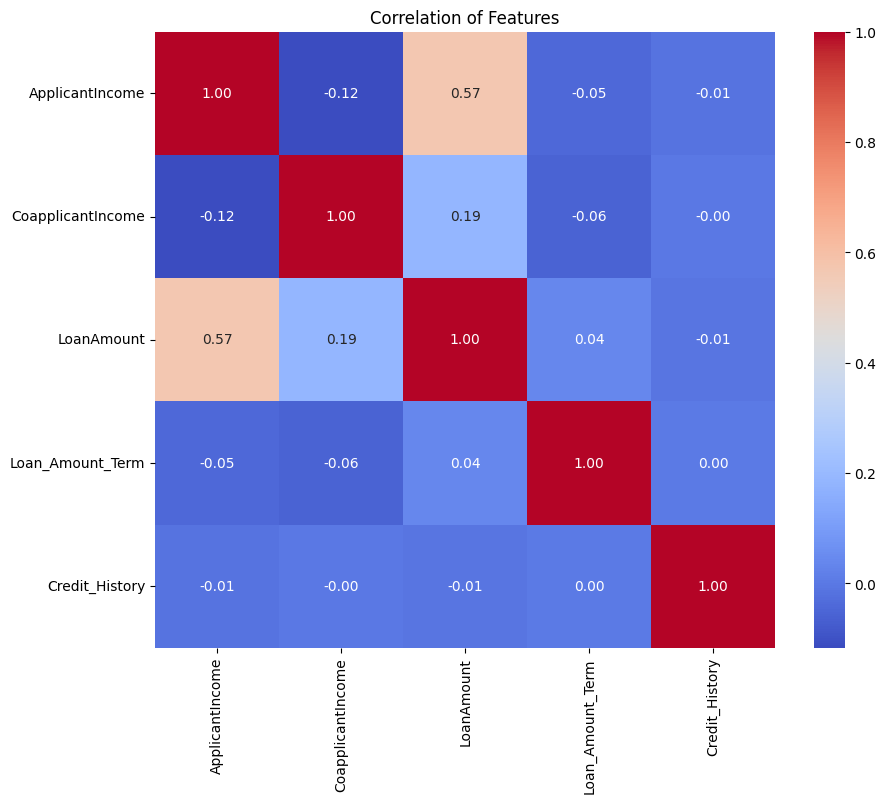

In [ ]:
# Посмотрим, какие признаки коррелируют друг с другом
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

# Создание подмножества данных с выбранными признаками
subset_df = df[features]

# Построение матрицы корреляции
correlation_matrix = subset_df.corr()

# Визуализация матрицы корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features')
plt.show()

Исходя из того, что тут есть ApplienceIncome коррелирует с LoanAmount, поэтому я бы не дропала пока эти два показателя.

<Axes: xlabel='Gender', ylabel='count'>

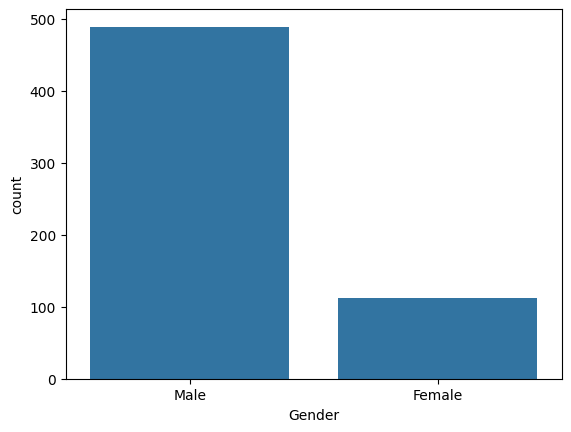

In [ ]:
# Короче говоря, нужно смотреть подробнее каждый признак, особенно те, которые имеют пропущенные значения, начнем с гендера
sns.countplot(x='Gender',data=df)

In [ ]:
# .isnull() будет находить пропущенные значения и производить замену всех пропущенных значений в столбце 'Gender' на строку 'Male': ='Male'
df['Gender'][df['Gender'].isnull()]='Male'

<Axes: xlabel='Married', ylabel='count'>

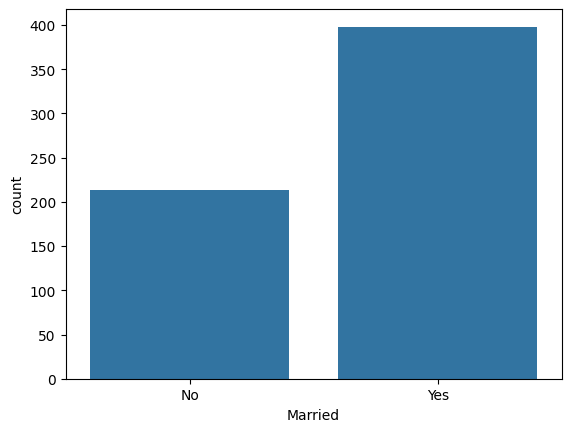

In [ ]:
sns.countplot(x='Married',data=df)

In [ ]:
# Делаем тоже самое, что и с гендером:
df['Married'][df['Married'].isnull()]='Yes'

In [ ]:
df['LoanAmount'][df['LoanAmount'].isnull()]= df['LoanAmount'].mean() # найдем пропущенные значения и заменим на среднее значение

<Axes: xlabel='Loan_Amount_Term', ylabel='count'>

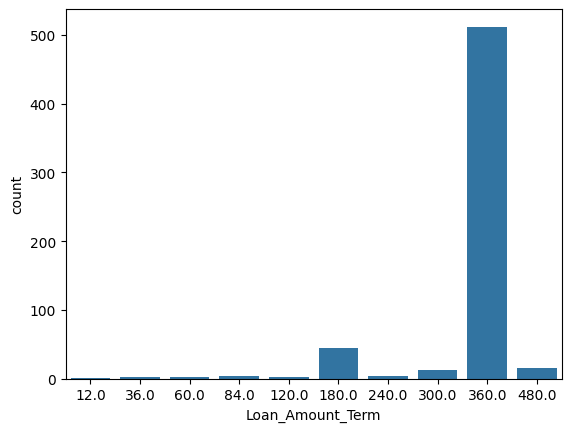

In [ ]:
sns.countplot(x='Loan_Amount_Term',data=df)

In [ ]:
df['Loan_Amount_Term'][df['Loan_Amount_Term'].isnull()]='360' # заменим на 360, т.к их значительно больше

<Axes: xlabel='Self_Employed', ylabel='count'>

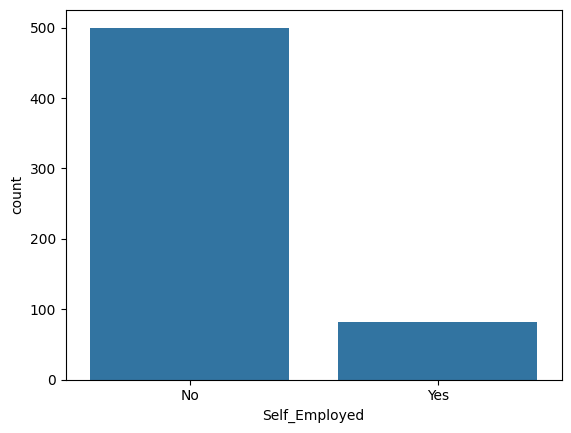

In [ ]:
sns.countplot(x='Self_Employed',data=df)

In [ ]:
df['Self_Employed'][df['Self_Employed'].isnull()]='No' # заменим на ноу, так как их больше

<Axes: xlabel='Credit_History', ylabel='count'>

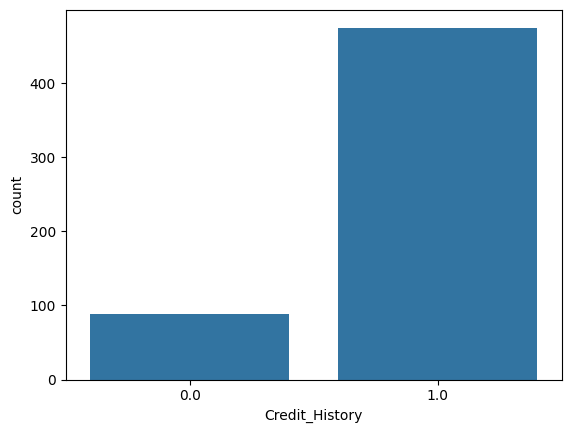

In [ ]:
sns.countplot(x='Credit_History',data=df)

In [ ]:
df['Credit_History'][df['Credit_History'].isnull()]='1'

In [ ]:
df.info()
# Осталось поработать с dependents

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    object 
 10  Credit_History     614 non-null    object 
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(2), int64(1), object(10)
memory usage: 62.5+ KB


<Axes: xlabel='Dependents', ylabel='count'>

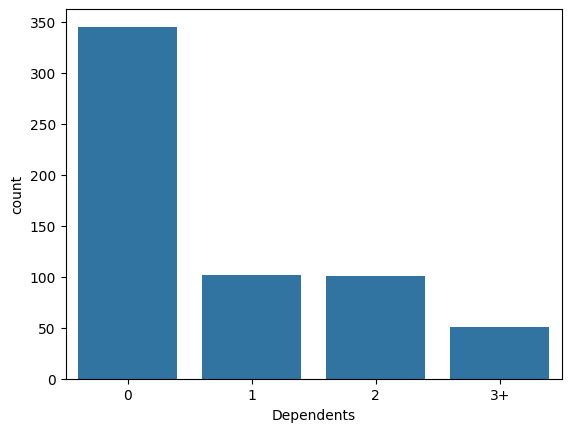

In [ ]:
sns.countplot(x='Dependents',data=df)

In [ ]:
df['Dependents'][df['Dependents'].isnull()]='0' #  тут придется поработать с 3+, т.к возможно его не заполнит

In [ ]:
df.loc[df.Dependents=='3+','Dependents']= 4

In [ ]:
df.tail()
# Посмотрим, были ли выполнены замены значений правильно, посмотрим на обновленные данные
# Да, вроде бы получилось

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,4,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [ ]:
# Теперь нужно категориальные признаки преобразовать в числовые, нужно поработать с Loan_ID, education, gender, married, property_area, loan_status
df.loc[df.Loan_Status=='N','Loan_Status']= 0
df.loc[df.Loan_Status=='Y','Loan_Status']=1
df.loc[df.Gender=='Male','Gender']= 0
df.loc[df.Gender=='Female','Gender']=1
df.loc[df.Married=='No','Married']= 0
df.loc[df.Married=='Yes','Married']=1
df.loc[df.Education=='Graduate','Education']= 0
df.loc[df.Education=='Not Graduate','Education']=1
df.loc[df.Self_Employed=='No','Self_Employed']= 0
df.loc[df.Self_Employed=='Yes','Self_Employed']=1
# Функция pd.get_dummies() преобразует категориальную переменную в несколько бинарных переменных.
# Параметр 'drop_first=True' означает, что первая из созданных dummy-переменных будет отброшена (это делается для избежания мультиколлинеарности).
property_area= pd.get_dummies(df['Property_Area'],drop_first=True)
df= pd.concat([df,property_area],axis=1)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Semiurban,Urban
0,LP001002,0,0,0,0,0,5849,0.0,146.412162,360.0,1.0,Urban,1,0,1
1,LP001003,0,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,Rural,0,0,0
2,LP001005,0,1,0,0,1,3000,0.0,66.000000,360.0,1.0,Urban,1,0,1
3,LP001006,0,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,Urban,1,0,1
4,LP001008,0,0,0,0,0,6000,0.0,141.000000,360.0,1.0,Urban,1,0,1


In [ ]:
# Дропну некоторые признаки
X = df.drop(['Loan_ID','Property_Area','Loan_Status'],axis=1)
y = df['Loan_Status']

In [ ]:
# Преобразование текстовых меток в числовой формат
# LabelEncoder из библиотеки scikit-learn предназначен для кодирования целевых меток (y) в виде целых чисел
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Масштабирование числовых признаков
scaler = StandardScaler()
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_features] = scaler.fit_transform(data[numeric_features])

Разделим на трейн и тест.

Соберем пайплайн: комбайн, который будет внутри себя сразу гонять и масштабирование, и модель

Альтернативный вариант:

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [ ]:
# разделим данные
X_train, X_test, y_train, y_test = train_test_split(X, y)
# Использую Pipeline и обучу модель Logistic Regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])
pipe.fit(X_train, y_train)

ypred_train = pipe.predict(X_train)
ypred_test = pipe.predict(X_test)

print(classification_report(ypred_train, y_train), classification_report(ypred_test, y_test))

              precision    recall  f1-score   support

           0       0.46      0.91      0.61        76
           1       0.98      0.79      0.87       384

    accuracy                           0.81       460
   macro avg       0.72      0.85      0.74       460
weighted avg       0.89      0.81      0.83       460
               precision    recall  f1-score   support

           0       0.35      0.94      0.51        16
           1       0.99      0.80      0.88       138

    accuracy                           0.81       154
   macro avg       0.67      0.87      0.70       154
weighted avg       0.92      0.81      0.84       154



В чем между ними разница? Во-первых, второе - упрощенный синтаксис, вы не прописываете вручную ярлычки для своих шагов пайплайна. Во-вторых, получается, эти ярлычки приписываются автоматически (по правилу: название класса строчными буквами, например, у StandardScaler автоматически будет ярлычок standardscaler). Это сакральное знание пригодится, когда будем гридсерчить параметры.

### Несбалансированные классы

Давайте порешаем еще одну финансовую задачку: будем предсказывать, возьмет клиент банка кредит или нет.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('bank.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Для начала просто дропнем все нечисловые характеристики.

In [ ]:
X = data.select_dtypes(include=np.number) # выбирает только столбцы с числовыми данными из набора данных data и присваивает их переменной X
# select_dtypes позволяет выбирать столбцы по типу данных
y = data.y # выбирает столбец с названием y из набора данных data и присваивает его переменной y

Проверим распределение классов:

In [ ]:
y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Обучите обычную логистическую регрессию на этом датасете и выведите classification report.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) # параметр stratify делает подвыборки с равномерным (по возможности) распределением классов

In [ ]:
# Масштабирование:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Обучение линейной регрессии
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Предсказания на обучающем и тестовом наборах
y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)
# Вывод отчета классификации
print("Classification Report for Training Set:")
print(classification_report(y_train, y_pred_train))

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred_test))

Classification Report for Training Set:
              precision    recall  f1-score   support

          no       0.93      0.97      0.95     27411
         yes       0.66      0.38      0.49      3480

    accuracy                           0.91     30891
   macro avg       0.79      0.68      0.72     30891
weighted avg       0.90      0.91      0.90     30891


Classification Report for Test Set:
              precision    recall  f1-score   support

          no       0.93      0.98      0.95      9137
         yes       0.69      0.39      0.50      1160

    accuracy                           0.91     10297
   macro avg       0.81      0.68      0.73     10297
weighted avg       0.90      0.91      0.90     10297



In [ ]:
# Метрики, оценка модели
 # confusion_matrix and classification_report for evaluating the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
y_pred =logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100)) # преобразуем точность из десятичной дроби в проценты и выделим с помощью 2f 2 знака после точки

Accuracy: 91.15%


Какие выводы можете сделать на основании метрик?
Посмотрим на каждый показатель:

1. Точность (Precision)
Для класса "yes" (клиенты, которые взяли кредит) точность модели ниже, составляет около 0.66 на обучающем наборе и 0.67 на тестовом наборе.
Для класса "no" (клиенты, которые не взяли кредит) значения не поменялись.

2. Полнота (Recall)
Для класса "no" полнота выше, что означает, что модель хорошо определяет тех клиентов, которые не взяли кредит.
Для класса "yes" полнота (recall) относительно низкая, что может указывать на сложности модели в определении клиентов, которые взяли кредит.

3. F1-мера (F1-score)

F1-мера - это гармоническое среднее точности и полноты. Модель показывает более высокую F1-меру для класса "no", чем для класса "yes".

Точность модели (Accuracy):
Общая точность модели на тестовом наборе составляет примерно 91%, то есть такое достаточно большое количество наблюдений были классифицированы правильно.


А теперь давайте применим особую магию с class_weight.

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[8932  205]
 [ 706  454]]


Матрица ошибок.
Верные предсказания (True Positives, True Negatives):

True Negatives (TN): Количество отрицательных случаев, которые модель правильно предсказала.

True Positives (TP): Количество положительных случаев, которые модель правильно предсказала.

Ошибочные предсказания (False Positives, False Negatives):

False Negatives (FN): Количество положительных случаев, которые модель неправильно предсказала как отрицательные.

False Positives (FP): Количество отрицательных случаев, которые модель неправильно предсказала как положительные.

  - 8932 верных отрицательных предсказаний (True Negatives, TN).
  - 454 верных положительных предсказаний (True Positives, TP).
  - 706 случаев, где модель неправильно предсказала положительные случаи как отрицательные (False Negatives, FN).
  - 205 случаев, где модель неправильно предсказала отрицательные случаи как положительные (False Positives, FP).

Однако существует проблема с class_weight. Основная проблема, связанная с весами несбалансированных классов, - это точность.

Точность, получаемая может быть высока, но важно то, насколько она правильна. Для весов несбалансированных классов получаемая точность, как правило, была бы высокой, поскольку она была бы смещена в сторону наиболее часто встречающегося класса, поскольку учитывала бы более высокие веса классов.

Таким образом, если дисбаланс классов в данных не будет устранен, это приведет к неправильной интерпретации модели.

<Axes: xlabel='count', ylabel='y'>

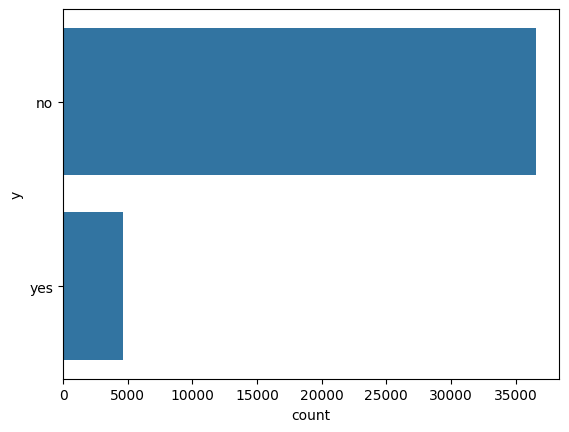

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y) # неравномерное распределение целевой переменной
# можно увидеть, что целевая переменная не сбалансирована, класс - no имеет большие веса по сравнению с классом yes

Веса классов можно сбалансировать с помощью модели логистической регрессии, просто объявив параметр class_weight сбалансированным в модели логистической регрессии.

Веса классов могут быть сбалансированы автоматически, минуя стандартный параметр, как сбалансировано в весах классов, или для каждой из категорий в данных могут быть предоставлены случайные веса для каждого из классов.

Модель логистической регрессии оснащается весами классов в качестве стандартного параметра как “сбалансированный”.

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight # импортировала класс весов
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Обучу модели с учетом сбалансированных классов
logreg_balanced = LogisticRegression(class_weight='balanced') #  балансировка классов с использованием параметра class_weight='balanced
logreg_balanced.fit(X_train, y_train)
# Предсказания на обучающем и тестовом наборах
y_pred_train_balanced = logreg_balanced.predict(X_train)
y_pred_test_balanced = logreg_balanced.predict(X_test)
# Вывод отчета классификации для сбалансированной модели

print("Classification Report for Training Set (Balanced Model):")
print(classification_report(y_train, y_pred_train_balanced))

print("\nClassification Report for Test Set (Balanced Model):")
print(classification_report(y_test, y_pred_test_balanced))
# Оценка точности модели
accuracy_balanced = accuracy_score(y_test, y_pred_test_balanced)
print("Accuracy for Balanced Model: {:.2f}%".format(accuracy_balanced * 100))


Classification Report for Training Set (Balanced Model):
              precision    recall  f1-score   support

          no       0.98      0.85      0.91     27411
         yes       0.42      0.85      0.56      3480

    accuracy                           0.85     30891
   macro avg       0.70      0.85      0.74     30891
weighted avg       0.92      0.85      0.87     30891


Classification Report for Test Set (Balanced Model):
              precision    recall  f1-score   support

          no       0.98      0.85      0.91      9137
         yes       0.42      0.85      0.57      1160

    accuracy                           0.85     10297
   macro avg       0.70      0.85      0.74     10297
weighted avg       0.92      0.85      0.87     10297

Accuracy for Balanced Model: 85.32%


Accuracy: 85.32% (для сбалансированной модели)

F1-score для класса "yes" (человек взял кредит): 56% (обучающий набор) и 57% (тестовый набор).

Какие выводы можно из этого сделать?

После внесения балансировки классов, accuracy (точность) снизилась с 91% до 85%, что может быть обусловлено учетом дисбаланса классов и изменением весов классов.

F1-score для класса "yes" (где человек взял кредит) увеличился с 49% до 56% для обучающего набора и с 50% до 57% для тестового набора после балансировки, что указывает на улучшение работы модели в определении этого класса.

In [ ]:
# https://analyticsindiamag.com/handling-imbalanced-data-with-class-weights-in-logistic-regression/
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
# https://www.nickmccullum.com/python-machine-learning/logistic-regression-python/
# https://github.com/rsuh-python/mag2023/blob/main/CL/term02/03-LinearClassification/sem03.ipynb

Домашняя работа №3

Задача 1.

Поиграемся с датасетом про диабет (он совсем легкий).

Целевая переменная тут явно обозначена как Class variable (очевидно, есть у человека диабет или нет)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('Diabetes Binary Classification.csv')
data.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable (0 or 1)
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Number of times pregnant                                                  768 non-null    int64  
 1   Plasma glucose concentration a 2 hours in an oral glucose tolerance test  768 non-null    int64  
 2   Diastolic blood pressure (mm Hg)                                          768 non-null    int64  
 3   Triceps skin fold thickness (mm)                                          768 non-null    int64  
 4   2-Hour serum insulin (mu U/ml)                                            768 non-null    int64  
 5   Body mass index (weight in kg/(height in m)^2)                            768 non-null    float64
 6   Diabetes pedigree function                                         

In [4]:
# Смотрю пропущенные значения
data.isnull().sum()
# Какая прекрасная новость, ведь пропущенных значений нет

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class variable (0 or 1)                                                     0
dtype: int64

In [5]:
data.describe()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable (0 or 1)
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: >

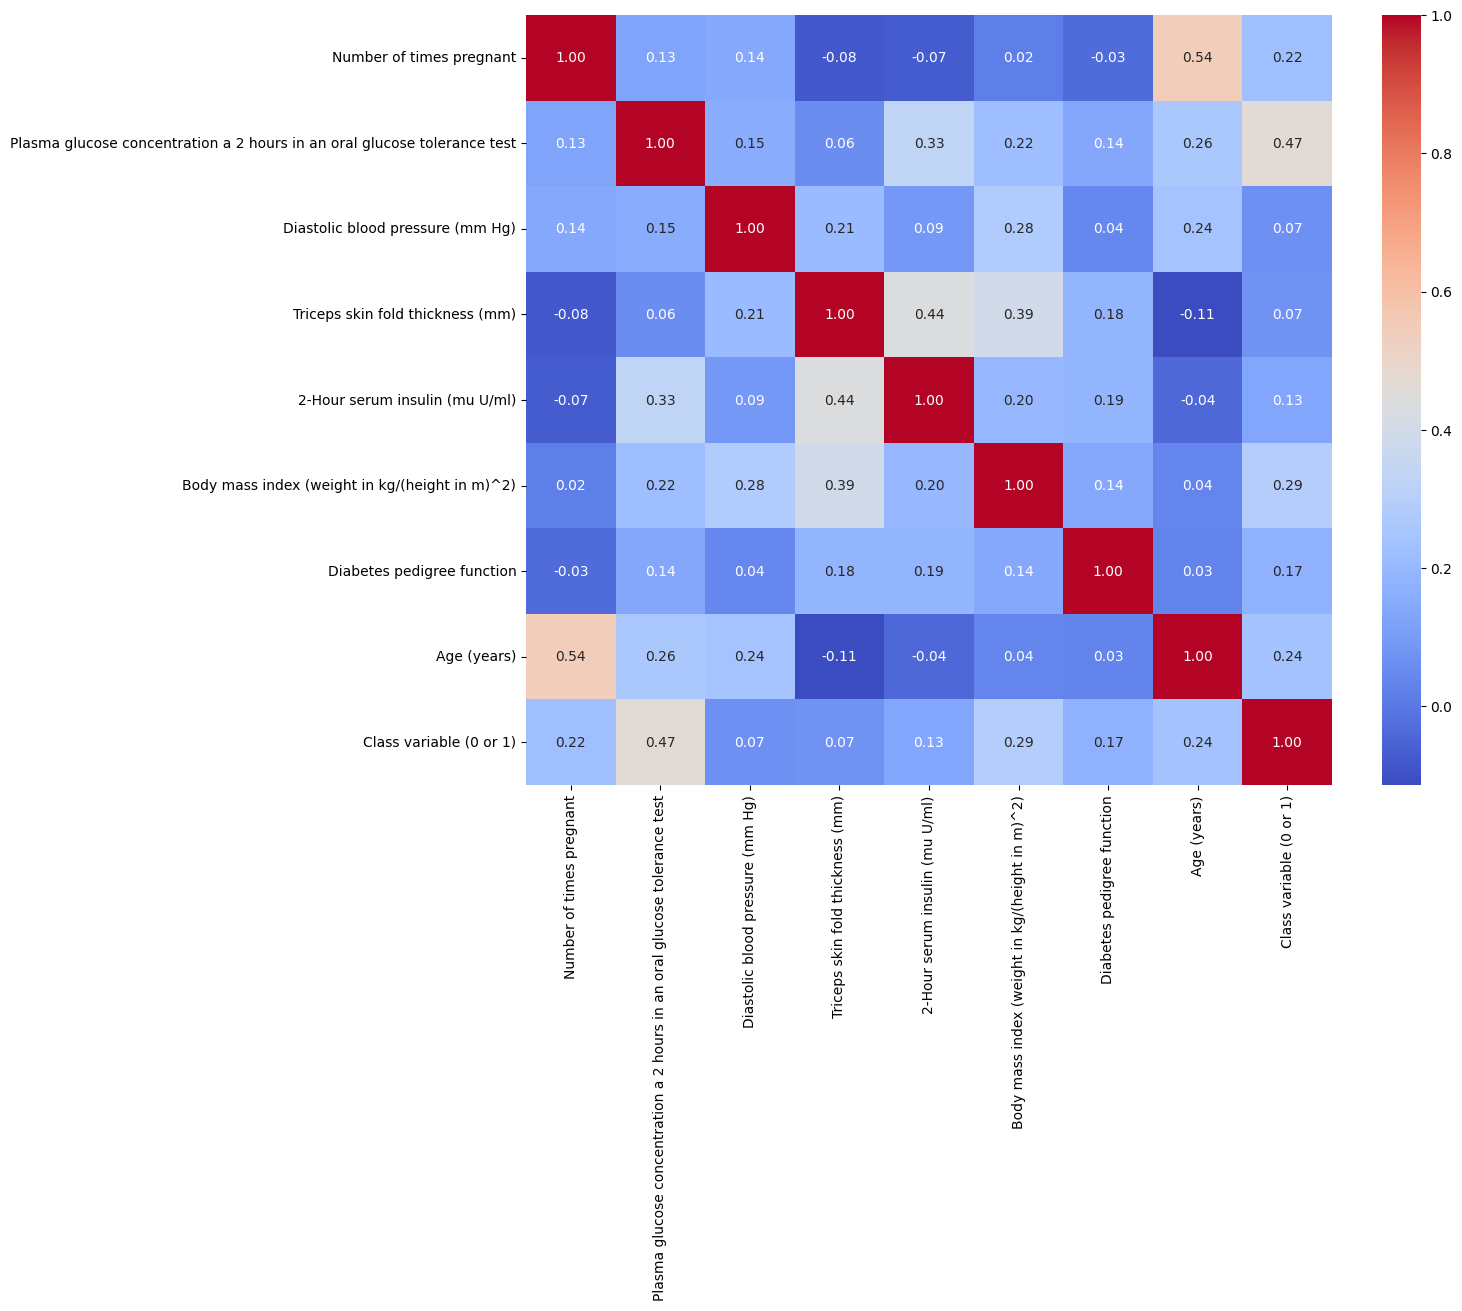

In [6]:
# Посмотрю на матрицу корреляций
plt.figure(figsize=(13,10))
sns.heatmap(data.corr(),annot=True, fmt = '.2f', cmap = 'coolwarm')

In [19]:
X = data.drop("Class variable (0 or 1)", axis=1)
y = data["Class variable (0 or 1)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
# Проверим распределение классов
y.value_counts()
# выборка не очень сбалансированная

0    500
1    268
Name: Class variable (0 or 1), dtype: int64

In [27]:
# разделим данные
# Использую Pipeline для масштабирования и обучу модель Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Разделим данные на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создам и обучу модель с использованием Pipeline
model = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])
model.fit(X_train, y_train)

# Предсказания
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Оценка качества модели с помощью classification_report
print("Classification Report for Training Data:")
print(classification_report(y_train, y_pred_train))
print("Classification Report for Test Data:")
print(classification_report(y_test, y_pred_test))

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       401
           1       0.72      0.56      0.63       213

    accuracy                           0.77       614
   macro avg       0.75      0.72      0.73       614
weighted avg       0.76      0.77      0.76       614

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154

Accuracy: 75.32%


Ну, неплохо, но есть куда улучшать выборку. Точность = 75%
F-1 на трейне = 0.83, 0.63
F-1 на тесте = 0.81, 0,66

Дропать еще признаки не очень хочется, т.к тут слишком много независимых, если я их всех удалю, то признаков останется только 2-4. Как мне кажется, они почти все влияют на диабет.

In [33]:
model.score(X_test, y_test)

0.7532467532467533

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[79 20]
 [18 37]]


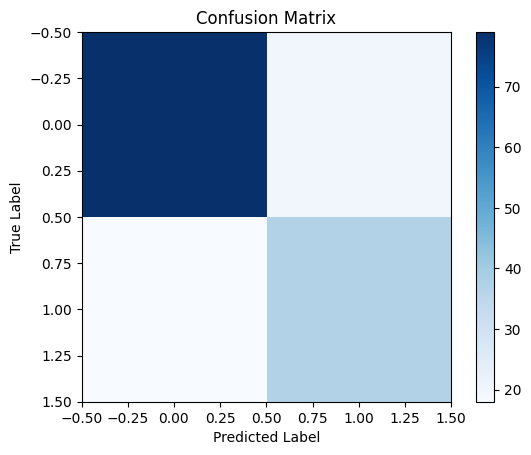

In [37]:
# Поистроим матрицу путаницы
# Интенсивность цвета представляет количество предсказаний
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Задача 2.

Второй датасет - про покупателей велосипедов.

Пытаемся по характеристикам человека понять, купит он велик или нет.

In [188]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [189]:
data = pd.read_csv('bike_buyers_clean.csv')
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes


In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                1000 non-null   int64 
 1   Marital Status    1000 non-null   object
 2   Gender            1000 non-null   object
 3   Income            1000 non-null   int64 
 4   Children          1000 non-null   int64 
 5   Education         1000 non-null   object
 6   Occupation        1000 non-null   object
 7   Home Owner        1000 non-null   object
 8   Cars              1000 non-null   int64 
 9   Commute Distance  1000 non-null   object
 10  Region            1000 non-null   object
 11  Age               1000 non-null   int64 
 12  Purchased Bike    1000 non-null   object
dtypes: int64(5), object(8)
memory usage: 101.7+ KB


<ipython-input-191-cfd9394db656>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = subset_df.corr()


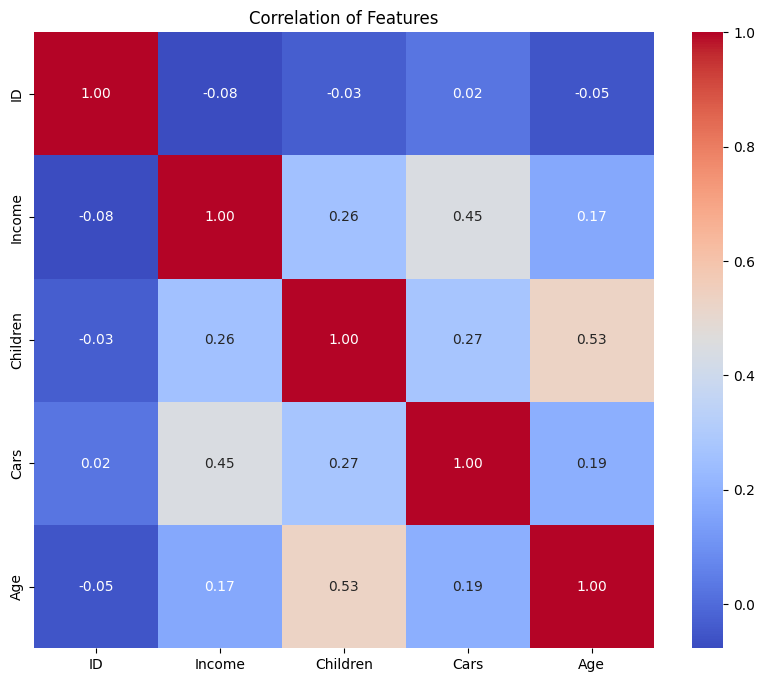

In [191]:
# Посмотрим, какие признаки коррелируют друг с другом
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['ID', 'Marital Status', 'Gender', 'Income', 'Children', 'Education', 'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region', 'Purchased Bike', 'Age']

# Создание подмножества данных с выбранными признаками
subset_df = data[features]

# Построение матрицы корреляции
correlation_matrix = subset_df.corr()

# Визуализация матрицы корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features')
plt.show()

In [192]:
data.describe()

,ID,Income,Children,Cars,Age
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,19965.992000,56140.000000,1.908000,1.452000,44.190000
std,5347.333948,31081.609779,1.626094,1.124705,11.353537
min,11000.000000,10000.000000,0.000000,0.000000,25.000000
25%,15290.750000,30000.000000,0.000000,1.000000,35.000000
50%,19744.000000,60000.000000,2.000000,1.000000,43.000000
75%,24470.750000,70000.000000,3.000000,2.000000,52.000000
max,29447.000000,170000.000000,5.000000,4.000000,89.000000


In [193]:
# Посмотрим пропущенные значения
data.isnull().sum()
# Нет пропущенных значений

ID                  0
Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
Purchased Bike      0
dtype: int64

In [194]:
data.dropna(inplace=True)

In [195]:
set(data.Region)

{'Europe', 'North America', 'Pacific'}

In [196]:
set(data.Occupation)

{'Clerical', 'Management', 'Manual', 'Professional', 'Skilled Manual'}

In [197]:
data['Commute Distance'].unique()

array(['0-1 Miles', '2-5 Miles', '5-10 Miles', '1-2 Miles', '10+ Miles'],
      dtype=object)

In [198]:
data['Purchased Bike'].unique()

array(['No', 'Yes'], dtype=object)

In [199]:
data.drop(['Education', 'Gender', 'Home Owner', 'ID', 'Marital Status'], axis=1, inplace=True)

In [200]:
data = data.fillna(data.mean())

<ipython-input-200-369509bb1069>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())


In [201]:
data['Commute Distance'] = data['Commute Distance'].map({'0-1 Miles': 0, '1-2 Miles': 1, '2-5 Miles': 2, '5-10 Miles': 3, '10+ Miles': 4})

In [112]:
# data['Purchased Bike'] = data.apply(lambda x : 0 if x['Purchased Bike'] == 'No' else 1, axis = 1)

In [202]:
data['Region'] = data['Region'].map({'Europe': 2, 'North America': 1, 'Pacific': 0,})

In [203]:
data['Occupation'] = data['Occupation'].map({'Clerical': 0, 'Management': 1, 'Manual': 2, 'Skilled Manual': 3})

In [204]:
data.head()

,Income,Children,Occupation,Cars,Commute Distance,Region,Age,Purchased Bike
0,40000,1,3.0,0,0,2,42,No
1,30000,3,0.0,1,0,2,43,No
2,80000,5,NaN,2,2,2,60,No
3,70000,0,NaN,1,3,0,41,Yes
4,30000,0,0.0,0,0,2,36,Yes


In [205]:
data.dropna(inplace=True)

In [206]:
data = data.fillna(data.mean())

<ipython-input-206-369509bb1069>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())


In [207]:
data.head()

,Income,Children,Occupation,Cars,Commute Distance,Region,Age,Purchased Bike
0,40000,1,3.0,0,0,2,42,No
1,30000,3,0.0,1,0,2,43,No
4,30000,0,0.0,0,0,2,36,Yes
5,10000,2,2.0,0,1,2,50,No
6,160000,2,1.0,4,0,0,33,Yes


In [208]:
# Преоразую в числовые:
# Преобразование категориальных признаков в числовые
data = pd.get_dummies(data, columns=['Occupation', 'Commute Distance', 'Region'])

In [209]:
# Масштабирование числовых признаков
scaler = StandardScaler()
data[['Income', 'Children', 'Cars', 'Age']] = scaler.fit_transform(data[['Income', 'Children', 'Cars', 'Age']])

In [214]:
X = data.drop('Purchased Bike', axis=1)
y = data['Purchased Bike']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [220]:
# Использую Pipeline для масштабирования и обучу модель Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Разделим данные на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

# Создам и обучу модель с использованием Pipeline
model = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])
model.fit(X_train, y_train)

# Предсказания
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Оценка качества модели с помощью classification_report
print("Classification Report for Training Data:")
print(classification_report(y_train, y_pred_train))
print("Classification Report for Test Data:")
print(classification_report(y_test, y_pred_test))

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Classification Report for Training Data:
              precision    recall  f1-score   support

          No       0.66      0.70      0.68       354
         Yes       0.61      0.56      0.58       297

    accuracy                           0.64       651
   macro avg       0.63      0.63      0.63       651
weighted avg       0.64      0.64      0.64       651

Classification Report for Test Data:
              precision    recall  f1-score   support

          No       0.64      0.74      0.69        39
         Yes       0.64      0.53      0.58        34

    accuracy                           0.64        73
   macro avg       0.64      0.64      0.64        73
weighted avg       0.64      0.64      0.64        73

Accuracy: 64.38%


Ну если честно, то точность предсказаний мне не очень нравится, даже class_weight не очень помог,(я пробовала, но там улучшалось буквально на 1 процент) мне кажется, что я где-то ошиблась.

Подскажите пожалуйста на что следует обратить внимание, если будет такая возможность, можно я эту задачку переделаю, если прям совсем она плохо у меня получилась.